In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
asset_name = "PETR4"
data_test_size = 14
dataset = pd.read_csv(f'dataset/{asset_name}.csv')
dataset_train = dataset[0:len(dataset)-data_test_size]
training_set = dataset_train.iloc[:, 1:2].values

In [4]:
training_set

array([[23.6 ],
       [23.5 ],
       [23.3 ],
       ...,
       [22.34],
       [23.49],
       [23.38]])

In [5]:
dataset_train

,date,val_high,val_open,val_low,val_close,val_close_final,volume,Moving average 7,Moving average 30,Momentum 7
0,2006-05-12,23.60,23.33,23.25,23.68,16.69,651535232,23.680000,23.680000,1.09
1,2006-05-15,23.50,23.25,22.40,23.45,16.53,1336049152,23.647143,23.672333,0.58
2,2006-05-16,23.30,23.12,22.60,22.85,16.10,671452672,23.528571,23.644667,-0.17
3,2006-05-17,23.08,22.73,22.00,23.00,16.21,601421120,23.431429,23.622000,0.59
4,2006-05-18,22.50,22.50,21.66,21.75,15.32,17677400,23.155714,23.557667,-0.62
...,...,...,...,...,...,...,...,...,...,...
3672,2021-03-08,22.28,21.94,20.96,21.10,21.10,141142800,21.875714,25.917000,-1.11
3673,2021-03-09,21.95,21.36,20.86,21.59,21.59,122648000,21.782857,25.696333,-0.22
3674,2021-03-10,22.34,21.94,21.58,22.34,22.34,111744100,21.831429,25.522667,0.89
3675,2021-03-11,23.49,22.62,22.61,23.29,23.29,130577500,22.017143,25.396000,0.84


In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
training_set_scaled.shape

(3677, 1)

In [8]:
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [11]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
114/114 [==============================] - 27s 115ms/step - loss: 0.0166
Epoch 2/100
114/114 [==============================] - 12s 107ms/step - loss: 0.0035
Epoch 3/100
114/114 [==============================] - 11s 96ms/step - loss: 0.0044
Epoch 4/100
114/114 [==============================] - 11s 98ms/step - loss: 0.0031
Epoch 5/100
114/114 [==============================] - 12s 101ms/step - loss: 0.0027
Epoch 6/100
114/114 [==============================] - 11s 95ms/step - loss: 0.0020
Epoch 7/100
114/114 [==============================] - 11s 95ms/step - loss: 0.0020
Epoch 8/100
114/114 [==============================] - 11s 95ms/step - loss: 0.0017
Epoch 9/100
114/114 [==============================] - 10s 92ms/step - loss: 0.0017
Epoch 10/100
114/114 [==============================] - 11s 101ms/step - loss: 0.0019
Epoch 11/100
114/114 [==============================] - 12s 101ms/step - loss: 0.0016
Epoch 12/100
114/114 [==============================] - 12s 103ms/ste

In [12]:
dataset_test = dataset[len(dataset)-data_test_size:]
real_stock_price = dataset_test.iloc[:, 1:2].values

In [13]:
dataset_total = pd.concat((dataset_train['val_open'], dataset_test['val_open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 60+data_test_size):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

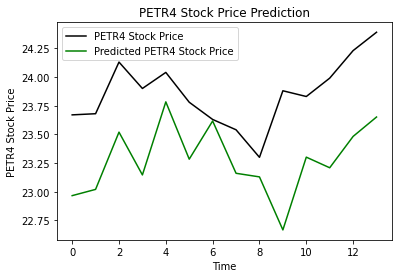

In [14]:
plt.plot(real_stock_price, color = 'black', label = f'{asset_name} Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = f'Predicted {asset_name} Stock Price')
plt.title(f'{asset_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{asset_name} Stock Price')
plt.legend()
plt.show()